# USING TWITTER TO COLLECT TWEETS BY BY UGANDAN "INFLUENCERS" TO DO SOME NATURAL LANGUAGE PROCESSING AND OR SENTIMENT ANALYSIS

In [2]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import tweepy
import csv
import json
import re
import wget
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from wordcloud import WordCloud

style.use('fivethirtyeight')
warnings.filterwarnings("ignore", category=DeprecationWarning)





class twitter_analysis:
    def __init__(self,file):
        with open(file) as cred_data:
            
            self.info = json.load(cred_data)
            self.api_key = self.info['API_KEY']
            self.api_secret = self.info['API_SECRET']
            self.access_token_key = self.info['ACCESS_TOKEN_KEY']
            self.access_token_secret = self.info['ACCESS_TOKEN_SECRET']
    
    def get_all_tweets(self,screen_name):
        

        # Twitter allows access to only 3240 tweets via this method

        # Authorization and initialization

        auth = tweepy.OAuthHandler(self.api_key, self.api_secret)
        auth.set_access_token(self.access_token_key, self.access_token_secret)
        api = tweepy.API(auth)

        # initialization of a list to hold all Tweets

        all_the_tweets = []

        # We will get the tweets with multiple requests of 200 tweets each

        new_tweets = api.user_timeline(screen_name=screen_name, count=200)

        # saving the most recent tweets

        all_the_tweets.extend(new_tweets)

        # save id of 1 less than the oldest tweet

        oldest_tweet = all_the_tweets[-1].id - 1

        # grabbing tweets till none are left

        while len(new_tweets):
            # The max_id param will be used subsequently to prevent duplicates
            new_tweets = api.user_timeline(screen_name=screen_name,
            count=200, max_id=oldest_tweet)

            # save most recent tweets

            all_the_tweets.extend(new_tweets)

            # id is updated to oldest tweet - 1 to keep track

            oldest_tweet = all_the_tweets[-1].id - 1
            print ('...%s tweets have been downloaded so far' % len(all_the_tweets))

            # transforming the tweets into a 2D array that will be used to populate the csv

            outtweets = [[tweet.id_str, tweet.created_at,
            tweet.text.encode('utf-8'),[e['text'] for e in tweet._json['entities']['hashtags']],tweet.user.followers_count] for tweet in all_the_tweets]

            # writing to the csv file

            with open('tweets/'  + screen_name + '.csv', 'w', encoding='utf8') as f:
                writer = csv.writer(f)
                writer.writerow(['id', 'created_at', 'text','all_hashtags','followers'])
                writer.writerows(outtweets)


    #  below is a user-defined function to remove unwanted text patterns from the tweets
    def remove_pattern(self,input_txt, pattern):
        '''It takes two arguments, one is the original string of text and the other is the 
            pattern of text that we want to remove from the string.'''
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)

        return input_txt  

    def get_images(self):
        '''
            Downloading all images uploaded by a twitter user:
        '''
        auth = tweepy.OAuthHandler(self.api_key, self.api_secret)
        auth.set_access_token(self.access_token_key, self.access_token_secret)
        api = tweepy.API(auth)

        user = input("Enter twitter user_id - ")

        #Getting all tweets
        all_tweets = api.user_timeline(screen_name=user, count=200,
        include_rts=False, exclude_replies=True)

        last_tweet_id = all_tweets[-1].id

        #Getting more tweets
        while True:
            more_tweets = api.user_timeline(screen_name=user, count=200,include_rts=False,exclude_replies=True,
            max_id=last_tweet_id - 1)

            if len(more_tweets) == 0:
                break
            else:
                last_tweet_id = more_tweets[-1].id - 1
                all_tweets = all_tweets + more_tweets

            image_files = set()
            for status in all_tweets:
                media = status.entities.get('media', [])
                if len(media):
                    image_files.add(media[0]['media_url'])

            print ('Downloading ' + str(len(image_files)) + ' images.....')
            for image_file in image_files:
                wget.download(image_file)


    def extract_hashtags(self, hashtag_phrase):
        
        """
        INPUTS:
            hashtag_phrase: the combination of hashtags to search for
        OUTPUTS:
            none, simply save the tweet info to a spreadsheet


        """
        
        #create authentication for accessing Twitter
        auth = tweepy.OAuthHandler(api_key, api_secret)
        auth.set_access_token(access_token_key, access_token_secret)

        #initialize Tweepy API
        api = tweepy.API(auth)

        #get the name of the spreadsheet we will write to
        fname = '_'.join(re.findall(r"#(\w+)", hashtag_phrase))

        #open the spreadsheet we will write to
        with open('hashtags/' + hashtag_phrase + '.csv', 'w') as file:

            w = csv.writer(file)

            #write header row to spreadsheet
            w.writerow(['timestamp', 'tweet_text', 'username', 'all_hashtags', 'followers_count'])
            print(f'Downloading tweets with #{hashtag_phrase}...\n')
            #for each tweet matching our hashtags, write relevant info to the spreadsheet
            for tweet in tweepy.Cursor(api.search, q=hashtag_phrase+' -filter:retweets', \
                                       lang="en", tweet_mode='extended').items(500):
                w.writerow([tweet.created_at, tweet.full_text.replace('\n',' ').encode('utf-8'), \
                            tweet.user.screen_name.encode('utf-8'), [e['text'] for e in tweet._json['entities']['hashtags']],\
                            tweet.user.followers_count])
                
            print('...DONE!')

In [5]:
if __name__ == "__main__":
    
    tweets = twitter_analysis('twitter_credentials.json')
    #hashtag_phrase = input('Hashtag Phrase ')
    
    #tweets.get_all_tweets(input('Screen name  : '))

In [7]:
x = pd.read_csv('tweets/AldrineEsther_tweets.csv')

# create a new column tidy_tweet, it will contain the cleaned and processed tweets
# remove twitter handles (@user)
x['tidy_tweet'] = np.vectorize(tweets.remove_pattern)(x['text'], "@[\w]*")

# Removing Punctuations, Numbers, and Special Characters
x['tidy_tweet'] = x['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

# Removing Short Words
x['tidy_tweet'] = x['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# Tokenization
tokenized_tweet = x['tidy_tweet'].apply(lambda x: x.split())

# Stemming
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

#let’s stitch these tokens back together.
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

x['tidy_tweet'] = tokenized_tweet

In [8]:
x.head()

,id,created_at,text,tidy_tweet
0,1176525007733907457,2019-09-24 15:53:15,b'RT @unlce_Jamo: Hey tweeps support a bros hu...,tweep support bro hustl nfor photographi drone...
1,1176523795898781699,2019-09-24 15:48:26,b'RT @JoyNakandi: Which hairstyle looked good ...,which hairstyl look good http
2,1176523674247147520,2019-09-24 15:47:57,b'@JoyNakandi \xf0\x9f\x98\x8d\xf0\x9f\x98\x8d',
3,1176522418380333061,2019-09-24 15:42:57,b'@JoyNakandi I Love your hair\xf0\x9f\x98\xad...,love your hair
4,1176522050699177985,2019-09-24 15:41:30,b'RT @GuruBaker: This sister deserves a night ...,thi sister deserv night http ekxv


Story Generation and Visualization from Tweets

Before we begin exploration, we must think and ask questions related to the data in hand. A few probable questions are as follows:

    What are the most common words in the entire dataset?
    What are the most common words in the dataset for negative and positive tweets, respectively?
    How many hashtags are there in a tweet?
    Which trends are associated with my dataset?
    Which trends are associated with either of the sentiments? Are they compatible with the sentiments?


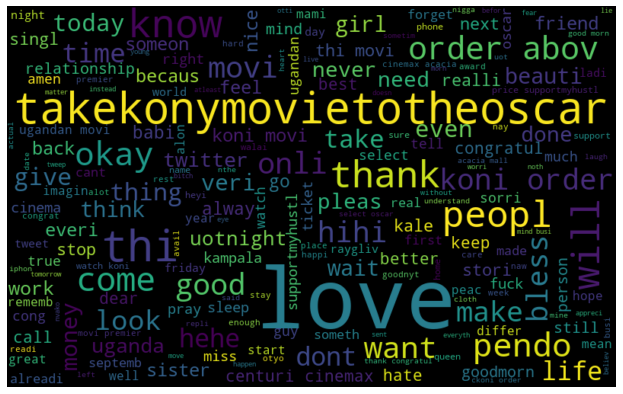

In [9]:
# Let’s visualize all the words our data using the wordcloud plot. 

all_words = ' '.join([text for text in x['tidy_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

